# Multi-label Classification with a Multi-Output Model

In this notebook we perform a multi-label classification with a multi-output model using TensorFlow Keras. 

We show how to build an arbitrary architecture (multi-output model) by using the following two Keras **Model APIs** (https://keras.io/api/models/):
- **Functional API**
- **Subclassing API** 


We use the MNIST dataset for the experimentation.

We define a problem in which each MNIST image has two labels:
- label 1: integer representing the class of the digit
- label 2: False/True (0/1) representing whether digit in the image is even/odd

Thus, we perform:
- Multi-class classification using label 1 (10 classes)
- Binary classification using label 2 (2 classes)

For each image we need to predict two output probabilities (i.e., probabilities of the class of the digit and even/odd). For this, we build a multi-output multi-class classifier, or simply a **multi-output classifier**.

The Sequential API of Keras doesn't support building multi-output Artificial Neural Networks (ANNs). We use the **Functional API** to do this. The functional API can handle models with nonlinear topology, models with shared layers, and models with multiple inputs or outputs.

    We will create two multi-output classifiers using the Functional API.

We also provide a brief note on the **Subclassing API** followed by code to implement a multi-output model.

In [1]:
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

## Load the Dataset

We load the train and test dataset using Keras datasets API. 

Then, we flatten the input images to create a 1D array for each image.

Finally, we scale the data.

In [2]:
mnist = tf.keras.datasets.mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Flatten the features to create a 1D array for each image
X_train_full = X_train_full.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)


# Create validation dataset as well as scale the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)


No. of Training Samples:  (55000, 784)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 784)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 784)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


## Create Binary Labels

Each target y_train/t_valid/y_test represents the underlying class of the digit in an image data using an integer between 0 to 9. This target is used for predicting the class of the digit via 10-class classification.

For predicting whether the digit is even or odd, we need to create another target.

In [3]:
# Binarize the Target: Create a new target to determine whether the digit is even or odd
y_train_binary_1D = (y_train % 2 == 0)
y_test_binary_1D = (y_test % 2 == 0)
y_valid_binary_1D = (y_valid % 2 == 0)


'''
The target "y_train/t_valid/y_test" are 1D arrays.
For each instance, it has just a target class index (0 or 1).
We want to compute one target probability per class for each instance.
I.e., each instance should have 2 probabilities for 2 classes.
Thus, we need to convert class indices (or sparse labels) to one-hot vector labels. 
The 1D target "y" would be converted to Nx2 matrix (N=number of samples)
We do this by using the keras.utils.to_categorical() function. 
'''

y_train_binary = tf.keras.utils.to_categorical(y_train_binary_1D)
y_test_binary = tf.keras.utils.to_categorical(y_test_binary_1D)
y_valid_binary = tf.keras.utils.to_categorical(y_valid_binary_1D)

## Create The Multi-Output Model using Keras Functional API

The Functional API is a way to create models that are more flexible than the Sequential API. The Functional API can handle models with 
- nonlinear topology
- shared layers
- multiple inputs or outputs. 

The Functional API is utilized for most use cases, and is known as the Keras "industry strength" model.

Considering the main idea that a deep learning model is usually a **directed acyclic graph (DAG)** of layers, the Functional API is a way to build graphs of layers.

Examples of some Deep ANNs (Convolutional Neural Networks) that have Functional characteristics (such as layer branching): ResNet, GoogLeNet/Inception, Xception, SqueezeNet


The Functional API enables us to create **arbitrary model architectures** by incorporating the following features:

    -- Shared layers inside the architecture
    -- Multiple inputs and multiple outputs
    -- Branches in your architectures (e.g., an Inception block in the following figure, ResNet block, etc.)
    -- Design directed acyclic graphs (DAGs)

Furthermore, any Sequential model can be implemented using Keras’ Functional API.

<img src="https://cse.unl.edu/~hasan/Pics/Keras_Functional_Model.png" width=600, height=300>


#### Creating a multi-output model using the Functional API is straightforward. We provide two examples of a multi-output model to solve our problem.


## Multi-Output Model 1

In this model, the input data goes through the **same two dense hidden layers**. Then, the last hidden layer passes the signal to two output layers (for multiclass and binary classification, respectively).

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          235500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          30100       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           1010        dense_1[0][0]                    
______________________________________________________________________________________________

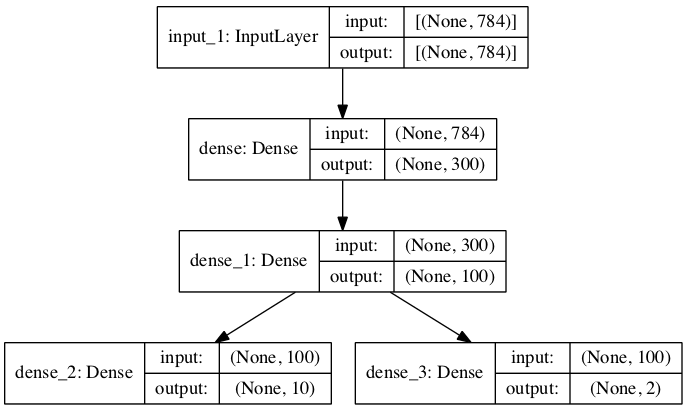

In [4]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Functional model. 
- First Layer (input_): It instantiates an input tensor for buildng the model 
- Hidden Layers: Dense hidden layer with the ReLU activation function
- Output Layer 1: Dense output layer with 10 neurons. Since it's a multi-class classification, we use "softmax"  
- Output Layer 2: Dense output layer with 2 neurons. Since it's a binary classification, we use "sigmoid"  
'''

input_ = tf.keras.Input(shape=(784,))
hidden1 = tf.keras.layers.Dense(300, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(100, activation="relu")(hidden1)
output1 = tf.keras.layers.Dense(10, activation="softmax")(hidden2)
output2 = tf.keras.layers.Dense(2, activation="sigmoid")(hidden2)

# Create a Model by specifying its input and outputs
model = tf.keras.models.Model(inputs=[input_], outputs=[output1, output2])

# Display the model summary
model.summary()

# Display the model graph
tf.keras.utils.plot_model(model, show_shapes=True)

## Create The Multi-Output Model using Keras Subclass API

The Subclassing API is used to implement **everything from scratch**, which is useful for complex, out-of-the-box research use cases. Model subclassing is fully-customizable and enables us to implement our own **custom forward-pass** of the model.

Since Keras utilizes object-oriented programming, we can subclass the Model class and then insert our architecture definition.

Defining a model using the Subclassing API involves 3 steps:

    -- Subclass the Model class
    -- Constructor (__init__): define the layers
    -- call() method: define the topology/graph of the network to perform forward pass computation
    
    
Unlike the Functional API (example above), we do not need to create the inputs (example below). We just use the input argument to the call() method, and separate the creation of the hidden layers in the constructor from their usage in the call() method. 

The **big difference** is that we can do pretty much anything we want in the call() method: 
- for loops
- if statements
- low-level TensorFlow operations, etc. 

This **flexibility of design** makes it a great API for experimenting with new ideas.
    
    
However, this extra flexibility does come at a **cost**. Our model’s architecture is hidden within the call() method, so Keras cannot easily inspect it; it cannot save or clone it; and when we call the summary() method, we only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless we really need that extra flexibility, we should probably stick to the Sequential API or the Functional API.


#### Below we provide the code for creating a multi-output MLP model using the Subclassing API. This is for illustration only. In the rest of the notebook we use the model created by the Functional API.

In [5]:
# Define the model class
class MultioutputModel(tf.keras.models.Model):

    def __init__(self, layer1Neurons=300, layer2Neurons=100, outputNeurons=10, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(layer1Neurons, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(layer2Neurons, activation=activation)
        self.output_multiclass = tf.keras.layers.Dense(10, activation="softmax")
        self.output_binary = tf.keras.layers.Dense(2, activation="sigmoid")


    def call(self, inputs):
        hidden1 = self.hidden1(inputs)
        hidden2 = self.hidden2(hidden1)
        output_multiclass = self.output_multiclass(hidden2)
        output_binary = self.output_binary(hidden2) 
        return output_multiclass, output_binary


    
    
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


# Create the model
model_subclassing = MultioutputModel(layer1Neurons=300, layer2Neurons=100, activation="relu")

## Multi-Output Model 1: Compile and Train

In [6]:
%%time

# Define the optimizer
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


'''
Compile the model.
Since we are using two different types of loss functions, we specify those using a list.
'''
model.compile(loss=["sparse_categorical_crossentropy", "binary_crossentropy"],
              optimizer=optimizer,
              metrics=["accuracy"])


# Create a callback object of early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify two types of labels for training and validation using lists.
'''
history = model.fit(X_train, [y_train, y_train_binary], 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=(X_valid, [y_valid, y_valid_binary]),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 2ms/step - loss: 0.3856 - dense_2_loss: 0.2555 - dense_3_loss: 0.1301 - dense_2_accuracy: 0.9236 - dense_3_accuracy: 0.9505 - val_loss: 0.1790 - val_dense_2_loss: 0.1212 - val_dense_3_loss: 0.0578 - val_dense_2_accuracy: 0.9630 - val_dense_3_accuracy: 0.9814
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1577 - dense_2_loss: 0.1026 - dense_3_loss: 0.0550 - dense_2_accuracy: 0.9686 - dense_3_accuracy: 0.9813 - val_loss: 0.1614 - val_dense_2_loss: 0.1039 - val_dense_3_loss: 0.0575 - val_dense_2_accuracy: 0.9678 - val_dense_3_accuracy: 0.9806
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1096 - dense_2_loss: 0.0710 - dense_3_loss: 0.0386 - dense_2_accuracy: 0.9779 - dense_3_accuracy: 0.9864 - val_loss: 0.1161 - val_dense_2_loss: 0.0785 - val_dense_3_loss: 0.0376 - val_dense_2_accuracy: 0.9766 - val_dense_3_accuracy: 0.9880
Epoch 4/100
1719/1719 [====================

## Multi-Output Model 1: Evaluation

The trained model predicts two types of output (output probability matrices):
- An N x 10 matrix for 10 class classification (digit)
- An N x 2 matrix for binary classification (even or odd)

We use these two predicted matrices to evaluate our model.

In [7]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)


train_evaluation = model.evaluate(X_train, [y_train, y_train_binary], verbose=0)
test_evaluation = model.evaluate(X_test, [y_test, y_test_binary], verbose=0)

print("\nTrain Evaluation: ", train_evaluation)
print("Test Evaluation: ", test_evaluation)


train_loss_multiclass = train_evaluation[1]
train_loss_binary = train_evaluation[2]
train_accuracy_multiclass = train_evaluation[3]
train_accuracy_binary = train_evaluation[4]

test_loss_multiclass = test_evaluation[1]
test_loss_binary = test_evaluation[2]
test_accuracy_multiclass = test_evaluation[3]
test_accuracy_binary = test_evaluation[4]


print("\n******************** Multiclass Classification ********************************************")


print("\nMulticlass Classification - Train Accuracy: ", train_accuracy_multiclass)
print("Multiclass Classification - Test Accuracy: ", test_accuracy_multiclass)

print("\nMulticlass Classification - Train Loss: ", train_loss_multiclass)
print("Multiclass Classification - Test Loss: ", test_loss_multiclass)


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted_multiclass = np.argmax(y_test_predicted[0], axis=1) # get the label/index of the highest probability class
y_test_predicted_binary = np.argmax(y_test_predicted[1], axis=1) # get the label/index of the highest probability class



# model.predict_classes(X_test) method returns the index (class label) with largest probability (1D array)
#y_test_predicted= model.predict_classes(X_test)


y_train_predicted = model.predict(X_train)
y_train_predicted_multiclass = np.argmax(y_train_predicted[0], axis=1) # get the label/index of the highest probability class
y_train_predicted_binary = np.argmax(y_train_predicted[1], axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix (Multiclass):")
print(confusion_matrix(y_test, y_test_predicted_multiclass))

print("\nClassification Report (Multiclass):")
print(classification_report(y_test, y_test_predicted_multiclass))



print("\n******************** Binary Classification ********************************************")



print("\nBinary Classification - Train Accuracy: ", train_accuracy_binary)
print("Binary Classification - Test Accuracy: ", test_accuracy_binary)

print("\nBinary Classification - Train Loss: ", train_loss_binary)
print("Binary Classification - Test Loss: ", test_loss_binary)


print("\nTest Confusion Matrix (Binary):")
print(confusion_matrix(y_test_binary_1D, y_test_predicted_binary))

print("\nClassification Report (Binary):")
print(classification_report(y_test_binary_1D, y_test_predicted_binary))

Epochs:  17

Train Evaluation:  [0.016048377379775047, 0.010388129390776157, 0.005660247057676315, 0.9974727034568787, 0.9985636472702026]
Test Evaluation:  [0.09672615677118301, 0.06507054716348648, 0.03165566548705101, 0.9818000197410583, 0.9891999959945679]

******************** Multiclass Classification ********************************************

Multiclass Classification - Train Accuracy:  0.9974727034568787
Multiclass Classification - Test Accuracy:  0.9818000197410583

Multiclass Classification - Train Loss:  0.010388129390776157
Multiclass Classification - Test Loss:  0.06507054716348648

Test Confusion Matrix (Multiclass):
[[ 971    0    2    1    0    0    2    0    2    2]
 [   0 1128    2    1    0    1    2    0    1    0]
 [   1    1 1015    1    2    0    2    3    6    1]
 [   0    0    4  995    0    2    0    5    2    2]
 [   1    0    2    0  964    0    4    1    1    9]
 [   2    0    0   12    2  859    5    1    7    4]
 [   5    2    1    1    6    2  938    

## Multi-Output Model 2

In this model, we pass the same input data through two paralel layers of dense hidden layers. Specifically, each input stream goes through the **two dense hidden layers** via two distinct branches. Then, we combine the final hidden layers of the two parallel branches. Finally, the combined hidden layer passes the signal to two output layers (for multiclass and binary classification, respectively).

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          235500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 300)          235500      input_2[0][0]                    
______________________________________________________________________________________________

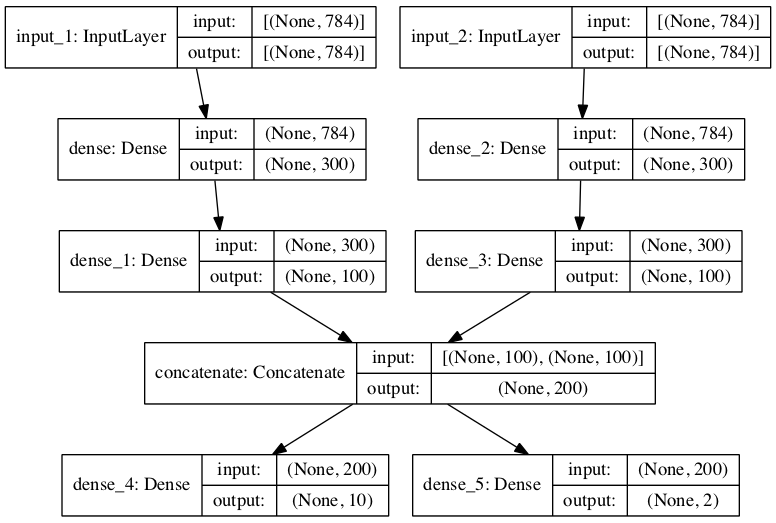

In [8]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Functional model. 
- Input Layer 1 (input1): It instantiates an input tensor for buildng the model 
- Branch 1: Two Hidden Layers: Dense hidden layer with the ReLU activation function

- Input Layer 2 (input2): It instantiates an input tensor for buildng the model 
- Branch 2: Two Hidden Layers: Dense hidden layer with the ReLU activation function
'''

input1 = tf.keras.Input(shape=(784,))
hidden1 = tf.keras.layers.Dense(300, activation="relu")(input1)
hidden2 = tf.keras.layers.Dense(100, activation="relu")(hidden1)

input2 = tf.keras.Input(shape=(784,))
hidden3 = tf.keras.layers.Dense(300, activation="relu")(input2)
hidden4 = tf.keras.layers.Dense(100, activation="relu")(hidden3)


'''
Combine the final hidden layers of the two parallel branches
'''
combined_hidden = tf.keras.layers.concatenate([hidden2, hidden4])

'''
The combined hidden layer passes the signal to two output layers 
(for multiclass and binary classification, respectively).
- Output Layer 1: Dense output layer with 10 neurons. Since it's a multi-class classification, we use "softmax"  
- Output Layer 2: Dense output layer with 2 neurons. Since it's a binary classification, we use "sigmoid"  
'''

output1 = tf.keras.layers.Dense(10, activation="softmax")(combined_hidden )
output2 = tf.keras.layers.Dense(2, activation="sigmoid")(combined_hidden )

# Create a Model by specifying its input and outputs
model = tf.keras.models.Model(inputs=[input1, input2], outputs=[output1, output2])


# Display the model summary
model.summary()

# Display the model graph
tf.keras.utils.plot_model(model, show_shapes=True)

## Multi-Output Model 2: Compile and Train

In [9]:
%%time

# Define the optimizer
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)


'''
Compile the model.
Since we are using two different types of loss functions, we specify those using a list.
'''
model.compile(loss=["sparse_categorical_crossentropy", "binary_crossentropy"],
              optimizer=optimizer,
              metrics=["accuracy"])


# Create a callback object of early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify
- two inputs (train & validation) for passing through two parallel branches
- two types of labels for training and validation using lists
'''
history = model.fit([X_train, X_train], [y_train, y_train_binary], 
                    batch_size=32, # batch size 32 is default
                    epochs=100,
                    verbose=1,
                    validation_data=([X_valid, X_valid], [y_valid, y_valid_binary]),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 2ms/step - loss: 0.3890 - dense_4_loss: 0.2541 - dense_5_loss: 0.1348 - dense_4_accuracy: 0.9250 - dense_5_accuracy: 0.9493 - val_loss: 0.1730 - val_dense_4_loss: 0.1157 - val_dense_5_loss: 0.0573 - val_dense_4_accuracy: 0.9674 - val_dense_5_accuracy: 0.9812
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1575 - dense_4_loss: 0.1011 - dense_5_loss: 0.0564 - dense_4_accuracy: 0.9702 - dense_5_accuracy: 0.9803 - val_loss: 0.1575 - val_dense_4_loss: 0.1030 - val_dense_5_loss: 0.0545 - val_dense_4_accuracy: 0.9682 - val_dense_5_accuracy: 0.9808
Epoch 3/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1061 - dense_4_loss: 0.0669 - dense_5_loss: 0.0391 - dense_4_accuracy: 0.9795 - dense_5_accuracy: 0.9862 - val_loss: 0.1082 - val_dense_4_loss: 0.0709 - val_dense_5_loss: 0.0372 - val_dense_4_accuracy: 0.9798 - val_dense_5_accuracy: 0.9870
Epoch 4/100
1719/1719 [====================

## Multi-Output Model 2: Evaluation

The trained model predicts two types of output (output probability matrices):
- An N x 10 matrix for 10 class classification (digit)
- An N x 2 matrix for binary classification (even or odd)

We use these two predicted matrices to evaluate our model.

In [10]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

# For evaluation, we need to pass two input matrices for the two parallel branches in the model
train_evaluation = model.evaluate([X_train, X_train], [y_train, y_train_binary], verbose=0)
test_evaluation = model.evaluate([X_test, X_test], [y_test, y_test_binary], verbose=0)

print("\nTrain Evaluation: ", train_evaluation)
print("Test Evaluation: ", test_evaluation)


train_loss_multiclass = train_evaluation[1]
train_loss_binary = train_evaluation[2]
train_accuracy_multiclass = train_evaluation[3]
train_accuracy_binary = train_evaluation[4]

test_loss_multiclass = test_evaluation[1]
test_loss_binary = test_evaluation[2]
test_accuracy_multiclass = test_evaluation[3]
test_accuracy_binary = test_evaluation[4]


print("\n******************** Multiclass Classification ********************************************")


print("\nMulticlass Classification - Train Accuracy: ", train_accuracy_multiclass)
print("Multiclass Classification - Test Accuracy: ", test_accuracy_multiclass)

print("\nMulticlass Classification - Train Loss: ", train_loss_multiclass)
print("Multiclass Classification - Test Loss: ", test_loss_multiclass)

# For evaluation, we need to pass two input matrices for the two parallel branches in the model
# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict([X_test, X_test])
y_test_predicted_multiclass = np.argmax(y_test_predicted[0], axis=1) # get the label/index of the highest probability class
y_test_predicted_binary = np.argmax(y_test_predicted[1], axis=1) # get the label/index of the highest probability class



# model.predict_classes(X_test) method returns the index (class label) with largest probability (1D array)
#y_test_predicted= model.predict_classes(X_test)


# For evaluation, we need to pass two input matrices for the two parallel branches in the model
y_train_predicted = model.predict([X_train, X_train])
y_train_predicted_multiclass = np.argmax(y_train_predicted[0], axis=1) # get the label/index of the highest probability class
y_train_predicted_binary = np.argmax(y_train_predicted[1], axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix (Multiclass):")
print(confusion_matrix(y_test, y_test_predicted_multiclass))

print("\nClassification Report (Multiclass):")
print(classification_report(y_test, y_test_predicted_multiclass))



print("\n******************** Binary Classification ********************************************")



print("\nBinary Classification - Train Accuracy: ", train_accuracy_binary)
print("Binary Classification - Test Accuracy: ", test_accuracy_binary)

print("\nBinary Classification - Train Loss: ", train_loss_binary)
print("Binary Classification - Test Loss: ", test_loss_binary)


print("\nTest Confusion Matrix (Binary):")
print(confusion_matrix(y_test_binary_1D, y_test_predicted_binary))

print("\nClassification Report (Binary):")
print(classification_report(y_test_binary_1D, y_test_predicted_binary))

Epochs:  20

Train Evaluation:  [0.004917769227176905, 0.002600786043331027, 0.002316989004611969, 0.999854564666748, 0.9997454285621643]
Test Evaluation:  [0.09090002626180649, 0.0571366511285305, 0.033763352781534195, 0.9836000204086304, 0.9889000058174133]

******************** Multiclass Classification ********************************************

Multiclass Classification - Train Accuracy:  0.999854564666748
Multiclass Classification - Test Accuracy:  0.9836000204086304

Multiclass Classification - Train Loss:  0.002600786043331027
Multiclass Classification - Test Loss:  0.0571366511285305

Test Confusion Matrix (Multiclass):
[[ 971    0    1    0    2    0    1    1    3    1]
 [   0 1125    2    2    0    1    2    1    2    0]
 [   3    1 1017    2    3    0    0    3    3    0]
 [   0    0    4  996    0    2    0    2    3    3]
 [   0    0    5    0  965    0    3    1    1    7]
 [   2    0    0    5    1  875    3    1    3    2]
 [   4    2    2    0    5    4  940    0  